### Load the dataset. Create an Analyzer object.

In [2]:
from sklearn import datasets
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')
import tabularmagic as tm

diabetes = datasets.load_diabetes()
data = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target = pd.Series(diabetes.target, name='target')
df = pd.concat([data, target], axis=1)

analyzer = tm.Analyzer(df, test_size=0.2)
analyzer

INFO: Analyzer initialized for dataset Unnamed Dataset. Shapes of train, test 
      DataFrames: (353, 11), (89, 11). 


Unnamed Dataset 
----------------------------------------------------------------------------------------
Train shape: (353, 11)                       Test shape: (89, 11)                       
----------------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                        
Numeric variables:
  'age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target' 

### Conduct exploratory analysis

Visualize the distribution of the target variable statified by sex

INFO: Working DataFrames reset to original DataFrames. Shapes of train, test DataFrames: 
      (353, 11), (89, 11). 


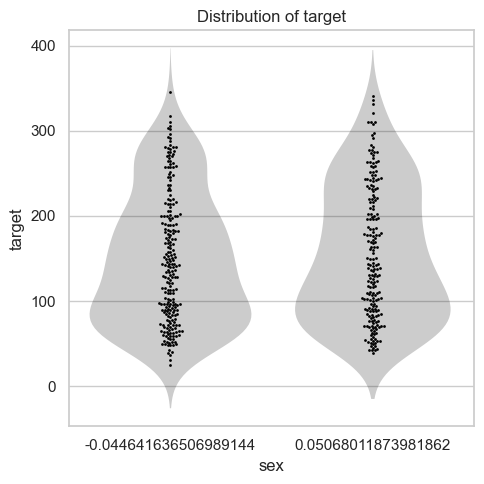

In [3]:
analyzer.datahandler().load_data_checkpoint() # load default data checkpoint
analyzer.eda(dataset='all').plot_distribution_stratified(
    'target', 'sex', strategy='violin_swarm'
)

Visualize the distribution of the target variable in relation with bmi, age, bp

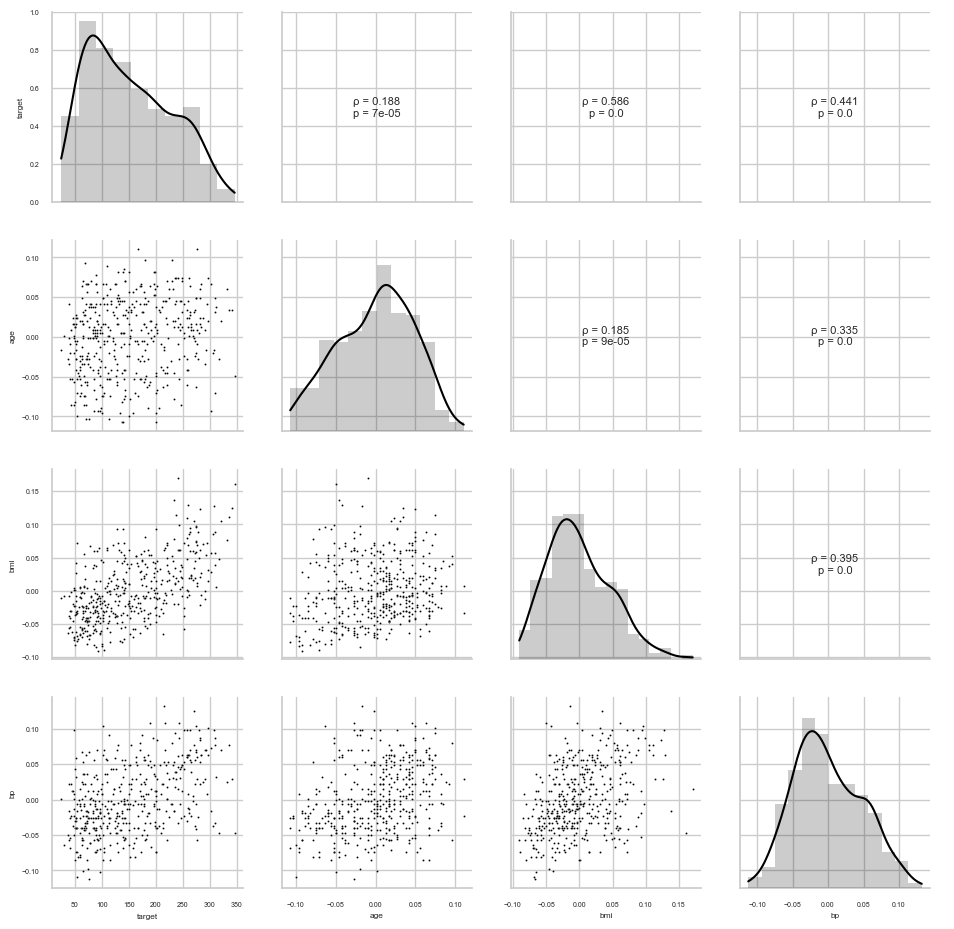

In [4]:
analyzer.eda(dataset='all').plot_numeric_pairs(
    ['target', 'age', 'bmi', 'bp'],
    figsize=(10, 10)
)

### Regression analysis

Fit a multivariate linear model

In [5]:
lm_report = analyzer.lm(
    formula='target ~ age + bmi + bp + sex + bp:sex'
)
lm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     78.41
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           7.28e-55
Time:                        15:41:15   Log-Likelihood:                -1940.0
No. Observations:                 353   AIC:                             3892.
Df Residuals:                     347   BIC:                             3915.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.4756      3.199     47.045      0.000     144.207     156.745
age           66.5596     68.288      0.975      0.330     -67.281     200.401
bmi          817.1307     75.365     10.842      0.000     669.417     964.844
bp           418.6492     75.770      5.525      0.000     270.143     567.155
sex         -110.2164     66.221     -1.664      0.096    -240.008      19.575
bp:sex      3082.4923   1304.186      2.364      0.018     526.334    5638.650
==============================================================================
Omnibus:                        9.655   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                5.330
Skew:                           0.072   Prob(JB):                       0.0696
Kurtosis:                       2.415   Cond. No.                         451.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

View the diagnostic plots

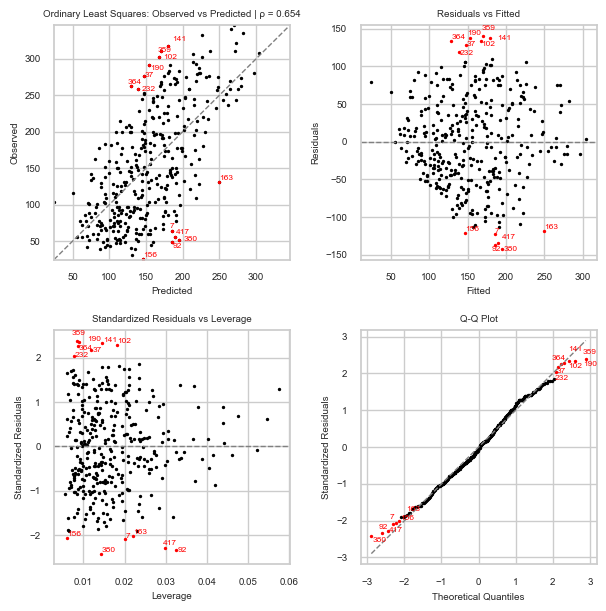

In [6]:
lm_report.train_report().set_outlier_threshold(2).plot_diagnostics(
    show_outliers=True
)

View model metrics

In [8]:
lm_report.metrics('train')

,Ordinary Least Squares
Statistic,
rmse,58.954531
mae,48.701527
mape,0.452445
pearsonr,0.654225
spearmanr,0.623311
r2,0.42801
n_obs,353


In [9]:
lm_report.metrics('test')

,Ordinary Least Squares
Statistic,
rmse,60.750438
mae,49.979177
mape,0.44503
pearsonr,0.561894
spearmanr,0.552851
r2,0.303415
n_obs,89


Perform stepwise selection

In [10]:
new_lm_report = lm_report.step('both', criteria='aic')
new_lm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     132.5
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           2.65e-57
Time:                        09:43:10   Log-Likelihood:                -1941.6
No. Observations:                 353   AIC:                             3891.
Df Residuals:                     349   BIC:                             3907.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.6212      3.203     47.024      0.000     144.343     156.899
bmi          827.4857     75.004     11.033      0.000     680.481     974.491
bp:sex      2882.5410   1317.697      2.188      0.029     299.902    5465.180
bp           414.1440     76.650      5.403      0.000     263.913     564.375
==============================================================================
Omnibus:                       11.827   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                6.194
Skew:                           0.093   Prob(JB):                       0.0452
Kurtosis:                       2.378   Cond. No.                         449.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### Machine learning regression benchmarking

Each model performs a grid search to find optimal estimator. Nested k-fold cross validation is performed to assess model fit on train. Models are also assesed on test.

In [14]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
import numpy as np

analyzer.load_data_checkpoint() # reset data to default checkpoint
analyzer.scale(
    include_vars=['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
    strategy='minmax'
)


ml_report = analyzer.regress(
    models=[
        tm.ml.CustomR(
            estimator=Lasso(alpha=0.1),
            name='Lasso alpha=0.1'
        ),
        tm.ml.CustomR(
            estimator=GridSearchCV(
                estimator=Lasso(alpha=0.5),
                param_grid={'alpha': np.logspace(-4, 4, 10)},
            ),
            name='Lasso with gridsearch'
        ),
        tm.ml.CustomR(
            estimator=Pipeline(
                steps=[
                    ('feature_selection', SelectKBest(k=2)),
                    ('regression', GridSearchCV(
                        estimator=Lasso(alpha=0.5),
                        param_grid={'alpha': np.logspace(-4, 4, 10)}
                    ))
                ]
            ),
            name='pipeline example'
        ),
        tm.ml.LinearR('l1'),
        tm.ml.TreesR('decision_tree')
    ],
    target='target',
    predictors=['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
    feature_selectors=[
        tm.fs.KBestFSR(k=3, scorer='f_regression')
    ],
    outer_cv=5,
    outer_cv_seed=0
)

INFO: Working DataFrames reset to original DataFrames. Shapes of train, test DataFrames: 
      (353, 11), (89, 11). 
INFO: Scaled variables 'age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6' using 
      strategy minmax. 
PROG: Fitting KBestFSR(f_regression). 
PROG: Fitting KBestFSR(f_regression). 
PROG: Fitting KBestFSR(f_regression). 
PROG: Fitting KBestFSR(f_regression). 
PROG: Fitting KBestFSR(f_regression). 
PROG: Fitting KBestFSR(f_regression). 
INFO: Evaluating model Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
INFO: Successfully evaluated model Lasso alpha=0.1. 
INFO: Evaluating model Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting La

View test fit statistics

In [10]:
ml_report.metrics('test')

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),TreesR(decision_tree)
Statistic,,,,,
rmse,54.206177,53.803383,53.865893,53.811334,62.442698
mae,43.995342,43.820968,44.009984,43.823205,50.03595
mape,0.38401,0.384076,0.392301,0.384046,0.471884
pearsonr,0.673068,0.676077,0.673287,0.676034,0.533313
spearmanr,0.662478,0.666547,0.659788,0.665781,0.517769
r2,0.445409,0.45362,0.45235,0.453459,0.264066
n_obs,89,89,89,89,89


View train fit statistics

In [11]:
ml_report.metrics('train')

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),TreesR(decision_tree)
Statistic,,,,,
rmse,54.704715,54.915672,57.370734,54.907837,61.245981
mae,44.862234,45.142201,47.561629,45.13346,50.470623
mape,0.402114,0.406024,0.423727,0.405904,0.435376
pearsonr,0.712477,0.71064,0.677011,0.710703,0.618613
spearmanr,0.696756,0.69477,0.66719,0.695087,0.623272
r2,0.507503,0.503698,0.45833,0.503839,0.382682
n_obs,353,353,353,353,353


View averaged fit statistics across folds

In [12]:
ml_report.cv_metrics()

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),TreesR(decision_tree)
Statistic,,,,,
rmse,55.721116,55.777427,59.198925,56.30482,65.367687
mae,45.771566,45.996111,49.377536,46.142784,53.242435
mape,0.40891,0.412127,0.439416,0.412132,0.45015
pearsonr,0.706652,0.705329,0.650214,0.699153,0.567518
spearmanr,0.681534,0.682666,0.645383,0.677234,0.592479
r2,0.479436,0.478461,0.408602,0.468148,0.284108
adjr2,0.402067,0.40095,0.320663,0.389098,0.177728
n_obs,70.6,70.6,70.6,70.6,70.6


Obtain the scikit-learn estimator for the TabularMagic lasso model

In [13]:
ml_report.model('LinearR(l1)').sklearn_estimator()

Lasso(alpha=0.3516577535232299, random_state=42, selection='random')

Obtain the pipeline for the TabularMagic lasso model

In [14]:
lasso_pipeline = ml_report.model('LinearR(l1)').sklearn_pipeline()

from joblib import dump, load
dump(lasso_pipeline, 'ignored/lasso_pipeline.joblib')

display(lasso_pipeline)

Pipeline(steps=[('custom_prep_data',
                 FunctionTransformer(check_inverse=False,
                                     func=<bound method DataEmitter.custom_transform of <tabularmagic._src.data.datahandler.DataEmitter object at 0x30ee85b50>>)),
                ('model',
                 OptunaSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                estimator=Lasso(random_state=42,
                                                selection='random'),
                                n_jobs=1, n_trials=100,
                                param_distributions={'alpha': FloatDistribution(high=10.0, log=True, low=1e-05, step=None)},
                                random_state=43))])

The pipeline can be used to predict from the data directly

In [15]:
lasso_pipeline = load('ignored/lasso_pipeline.joblib')
prediction = lasso_pipeline.predict(df[['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']])
target = df['target']

from sklearn.metrics import root_mean_squared_error
print(f'rmse: {root_mean_squared_error(target, prediction)}')

rmse: 54.688815333986575


Obtain the custom Pipeline

In [16]:
ml_report.model('pipeline example').sklearn_estimator()

Pipeline(steps=[('feature_selection', SelectKBest(k=2)),
                ('regression',
                 GridSearchCV(estimator=Lasso(alpha=0.5),
                              param_grid={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}))])

Obtain the same Pipeline but with preprocessing steps appended

In [17]:
ml_report.model('pipeline example').sklearn_pipeline()

Pipeline(steps=[('custom_prep_data',
                 FunctionTransformer(check_inverse=False,
                                     func=<bound method DataEmitter.custom_transform of <tabularmagic._src.data.datahandler.DataEmitter object at 0x30ee85b50>>)),
                ('model',
                 Pipeline(steps=[('feature_selection', SelectKBest(k=2)),
                                 ('regression',
                                  GridSearchCV(estimator=Lasso(alpha=0.5),
                                               param_grid={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}))]))])

View LinearR(l1) fit on train data

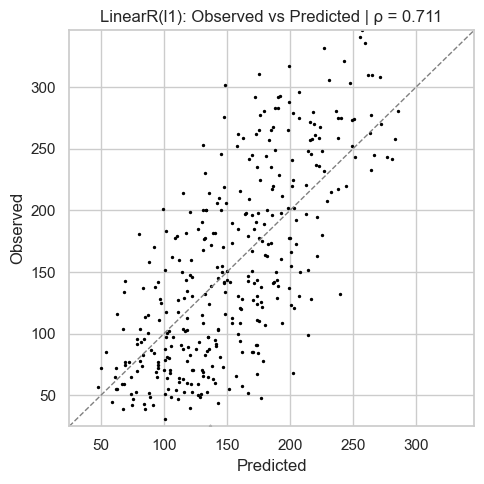

In [18]:
ml_report.plot_obs_vs_pred('LinearR(l1)', 'train')

View LinearR(l1) fit on test data

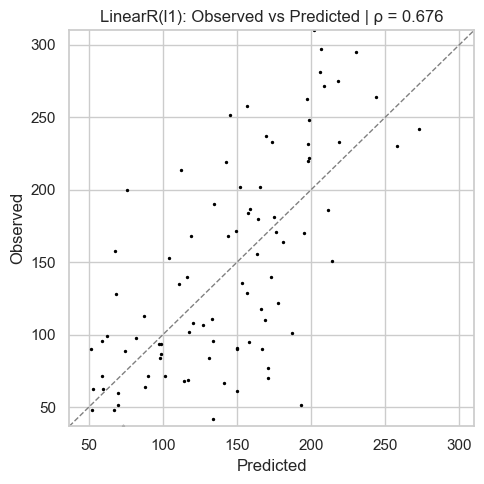

In [19]:
ml_report.plot_obs_vs_pred('LinearR(l1)', 'test')